# Testing virtual data set (VDS) local icechunk store for CCMP_WINDS_10M6HR_L4_V3.1

First test of saving a VDS to icechunk format. Uses the virtualizarr + icechunk workflow. CCMP_WINDS_10M6HR_L4_V3.1 (https://doi.org/10.5067/CCMP-6HW10M-L4V31) is an L4 data set with four time steps per granule. Will concatinate along time dimension.

This notebook creates a local icechunk VDS that points to S3 endpoints for NASA Earthdata, then tests opening the data and doing a basic subsetting, computation, and plot.

#### Minimum working environment

```
xarray==2025.4.0
h5netcdf==1.6.1
icechunk==0.2.15
virtualizarr==1.3.2
earthaccess==0.12.0
dask==2025.5.0
matplotlib==3.10.3
```

Maybe need to specify these as well? (probably get installed with earthaccess already)
```
fsspec==2025.3.2
s3fs==2025.3.2
```

In [1]:
# Built-in packages
import os
import sys
import shutil
from typing import Optional

# Filesystem management 
import earthaccess

# Data handling
import numpy as np
import xarray as xr
from virtualizarr import open_virtual_dataset
import icechunk

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client

# Other
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Get Data File S3 endpoints in Earthdata Cloud for first 100 files

In [3]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [4]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [4]:
# Locate CCMP file information / metadata:
granule_info = earthaccess.search_data(
    short_name="CCMP_WINDS_10M6HR_L4_V3.1",
    count=100
    )

In [5]:
# Get S3 endpoints for all files:
data_s3links = [g.data_links(access="direct")[0] for g in granule_info]
print("Number of granules found =", len(data_s3links))
print("First few granules:")
data_s3links[0:3]

Number of granules found = 100
First few granules:


['s3://podaac-ops-cumulus-protected/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_Wind_Analysis_19930102_V03.1_L4.nc',
 's3://podaac-ops-cumulus-protected/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_Wind_Analysis_19930103_V03.1_L4.nc',
 's3://podaac-ops-cumulus-protected/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_Wind_Analysis_19930105_V03.1_L4.nc']

## 2. Generate single-day reference files

One file per orbit, so one reference file per orbit.

In [8]:
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.

In [6]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["time", "latitude", "longitude"]

In [7]:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 4


In [5]:
# Start up cluster and print some information about it:
client = Client(n_workers=4, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(3c048b45, 'tcp://127.0.0.1:34289', workers=4, threads=4, memory=14.80 GiB)
View any work being done on the cluster here https://cluster-iewik.dask.host/jupyter/proxy/8787/status


In [10]:
%%time
# Create individual references:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:100]
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.

CPU times: user 4.85 s, sys: 786 ms, total: 5.63 s
Wall time: 52.4 s


In [11]:
len(virtual_ds_list)

100

## 3. Generate combined reference and save to icechunk

In [12]:
%%time
# Create the combined reference
virtual_ds_combined = xr.combine_nested(virtual_ds_list, concat_dim='time', coords='minimal', compat='override', combine_attrs='drop_conflicts')

CPU times: user 53.2 ms, sys: 0 ns, total: 53.2 ms
Wall time: 52.1 ms


In [19]:
def create_icechunk_repo_local(repo_name: str):
    """
    Creates an icechunk repository locally.

    Inputs
    ------
    * repo_name (str): path to icechunk repo.
    """
    storage = icechunk.local_filesystem_storage(path=repo_name)
    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3", "s3://", icechunk.s3_store(region="us-west-2")))
    credentials = icechunk.containers_credentials(s3=icechunk.s3_credentials(anonymous=True))
    return icechunk.Repository.create(storage, config, credentials)

In [21]:
# Create icechunk repo and session
repo = create_icechunk_repo_local("vds_icechunk_CCMP_WINDS_10M6HR_L4_V3.1")
session = repo.writable_session("main")

In [22]:
# Then write the VDS to the store:
virtual_ds_combined.virtualize.to_icechunk(session.store)
session.commit("My first virtual store!")

/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


'BBP1PV92D35QM3E7QYT0'

In [23]:
# Zip store for optional downloading later:
shutil.make_archive('vds_icechunk_CCMP_WINDS_10M6HR_L4_V3.1', 'zip', 'vds_icechunk_CCMP_WINDS_10M6HR_L4_V3.1')

'/scratch/notebook/vds_icechunk_CCMP_WINDS_10M6HR_L4_V3.1.zip'

## 4. Test icechunk store for combined reference

In [6]:
def get_icechunk_repo_local(repo_path: str, ea_creds: Optional[dict] = None):
    """
    Accesses a local icechunk repo and optionally appends Earthdata credentials to it.

    Inputs
    ------
    * repo_path (str): Path to icechunk repo.
    * ea_creds (dict, optional): Should contain values for 'accessKeyId', 'secretAccessKey', and 
        'sessionToken'.
    """
    
    storage = icechunk.local_filesystem_storage(path=repo_path)
    config = icechunk.RepositoryConfig.default()
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3", "s3://", icechunk.s3_store(region="us-west-2")))
    repo_config = dict(
        storage=storage,
        config=config,
    )
    
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            s3=icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken']
            )
        )
        repo_config['virtual_chunk_credentials'] = earthdata_credentials
        
    return icechunk.Repository.open(**repo_config)

In [7]:
## Access repo with earthaccess credentials added:
ea_creds = earthaccess.get_s3_credentials(daac='PODAAC')
repo = get_icechunk_repo_local(repo_path="vds_icechunk_CCMP_WINDS_10M6HR_L4_V3.1", ea_creds=ea_creds)
session = repo.readonly_session(branch="main")

In [8]:
## Use it to open data on Earthdata:
data = xr.open_zarr(
    session.store,
    zarr_format=3,
    consolidated=False,
    chunks={},
)
data

/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/coiled/env/lib/python3.13/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


<xarray.Dataset> Size: 7GB
Dimensions:    (latitude: 720, time: 400, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time       (time) datetime64[ns] 3kB 1993-01-02 ... 1993-04-12T18:00:00
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    nobs       (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/48)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    instrument:                    Earth Remote Sensing Instruments>Passive R...

In [9]:
## Test subsetting:
lat_range = (0, 45)
lon_range = (230, 260)
time_range = (np.datetime64("1993-01-02"), np.datetime64("1993-02-02"))
data_subset = data.sel(latitude=slice(*lat_range), longitude=slice(*lon_range), time=slice(*time_range))
data_subset

<xarray.Dataset> Size: 42MB
Dimensions:    (latitude: 180, time: 121, longitude: 120)
Coordinates:
  * latitude   (latitude) float32 720B 0.125 0.375 0.625 ... 44.38 44.62 44.88
  * time       (time) datetime64[ns] 968B 1993-01-02 ... 1993-02-02
  * longitude  (longitude) float32 480B 230.1 230.4 230.6 ... 259.4 259.6 259.9
Data variables:
    nobs       (time, latitude, longitude) float32 10MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 10MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 10MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 10MB dask.array<chunksize=(1, 180, 120), meta=np.ndarray>
Attributes: (12/48)
    contact:                       Remote Sensing Systems, support@remss.com
    Conventions:                   CF-1.7 ACDD-1.3
    data_structure:                grid
    title:                         RSS CCMP V3.1 6-hourly surface winds (Leve...
    summary:                       RSS VAM 6-hour analyses using ERA-5 wind r...
    institute_id:                  RSS
    ...                            ...
    keywords:                      EARTH SCIENCE > ATMOSPHERE > ATMOSPHERIC W...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform_vocabulary:           GCMD platform keywords
    instrument_vocabulary:         GCMD instrument keywords
    references:                    Mears, C.; Lee, T.; Ricciardulli, L.; Wang...
    instrument:                    Earth Remote Sensing Instruments>Passive R...

In [10]:
%%time
# Test computing mean windspeed over the subsetting region:
ws_mean_map = data_subset["ws"].mean(dim="time").compute()

CPU times: user 467 ms, sys: 63 ms, total: 530 ms
Wall time: 7.11 s


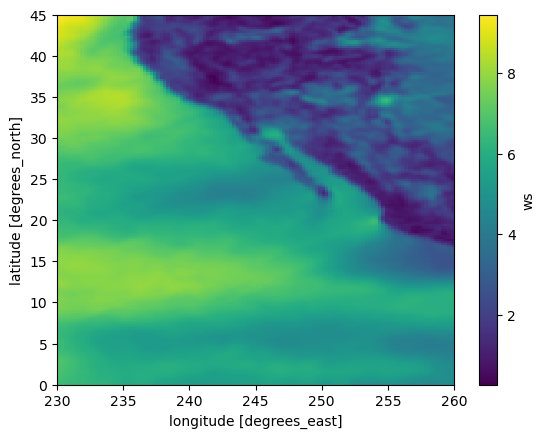

In [11]:
ws_mean_map.plot()

## Additional notes and next steps

* I was able to move the icechunk store from one VM to another and still use it.
* This store currently works only if it is on the local machine. There is an option to create / access a store in an S3 bucket, but we also want the option to access it via HTTPS. Icechunk / virtualizarr teams are currently working on this functionality and plan to release soon?